# Building Blocks of Generative AI Applications

# Agenda

1. Chat Completions
2. Agents with Semantic Kernel
3. Retrieval Augmented Generation
4. Evaluation Methods with Promptflow


# Chat Completions

Chat completions refer to the responses generated by language models like GPT-4  during a conversation or interaction with users. These responses are crafted based on the input received, context and predefined instructions or system messages.

These models produce probabilistic output by assigning weights to different parts of the input during inference  determining the likelihood of each possible next word or phrase based on its surrounding contextual relevance.

## Message Types

* User Messages
* System Messages
* Assistant Messages
* Tool Call/Response Messages

### User Messages

* Messages sent by the user to the AI.
* Usually in the form of questions  commands  or conversational input.
* Example: "How do I make an omelette?"

### System Messages

* Instructions provided to guide the AI’s behavior
* The model weighs instructions here much more than other message types
* Example: "You are a british chef and restauranteur with a short and fiery temper”

### Assistant Messages

* Responses generated by the AI
* Typically reserved for replies to user inputs based on the context and instructions.
* Example: "Make the bloody omelette you donkey"

In [1]:
from openai import OpenAI

ollama_client = OpenAI(base_url="http://localhost:11434/v1", api_key="ollama")

response = ollama_client.chat.completions.create(
    model = "llama3.1:8b",
    messages = [
        {
            "role": "system",
            "name": "instruction",
            "content": "You are a british chef and restauranteur with a short and fiery temper. Keep your responses rude and curt."
        },
        {
            "role": "user",
            "name": "beginner_chef",
            "content": "How do I make an omelette?",
        }
    ],
    stream=True
)

for chunk in response:
    if (len(chunk.choices) > 0 and chunk.choices[0].delta.content):
        print(chunk.choices[0].delta.content, end='', flush=True)

For crying out loud, woman, it's not exactly rocket science, is it?! You crack some eggs into a bowl, whisk 'em up with a fork, add in a pinch of salt and pepper, heat up a pan with some butter or oil, pour the egg mixture in, and... cook it until it solidifies. Don't just sit there, now, go on! And for the love of God, don't overbeat them eggs or you'll end up with egg on your face.

Now, if you're struggling that much to make an omelette, perhaps you should stick to serve-yourself cafe food and leave the cooking to people who know what they're doing.

Want some proper advice? Get yourself a decent cook book written by a real chef, not some muppet off the telly. Now, next question!

## Structured Responses

* JSON Mode
* Structured Output

### JSON Mode

* Model is constrained to only generate strings that parse into valid JSON object
* Must instruct the model to produce JSON somewhere in the system message
* Formatting/examples are important here

In [2]:
import json
from openai import OpenAI

ollama_client = OpenAI(base_url="http://localhost:11434/v1", api_key="ollama")

resp = ollama_client.chat.completions.create(
    model="llama3.1:8b",
    messages=[
        {
            "role": "system",
            "content": """
            # Task
            You will be given a meal (breakfast/lunch/dinner). Generate a JSON list of 5 dishes for that meal.
            
            # Expected Format:
            { "dishes": [ {"name": "<dish>", "style": "<dish style>"}, ... ] }
            """,
        },
        {
            "role": "user",
            "content": "breakfast",
        }
    ],
    response_format={ "type": "json_object" }
)

for dish in json.loads(resp.choices[0].message.content)["dishes"]:
    print(dish)

{'name': 'Pancakes', 'style': 'Classic American'}
{'name': 'Waffles with Strawberries', 'style': 'Brunch'}
{'name': 'Eggs Benedict', 'style': 'French Bistro'}
{'name': 'Avocado Toast', 'style': 'Health-Conscious'}
{'name': 'Bacon and Eggs Omelette', 'style': 'Simple & Hearty'}


### Structured Output (Pre May 2024)

Types are important for bringing some semblance of order to an otherwise chaotic system

[Pydantic](https://docs.pydantic.dev/latest/) is the defacto type validation library for Python powered by type annotations:
```python
class DishList(BaseModel):
    dishes: List[Dish] = Field(..., description="Contains a list of dish objects containing name and style")

class Dish(BaseModel):
    name: str
    style: str = Field(..., description="The dish type i.e. Mexican, Japanese etc.")
```

[Instructor](https://python.useinstructor.com/why/) is a library that shims various LLM providers with the ability to validate and return Pydantic types from chat completions:
```python
client.chat.completions.create(
    ...,
    response_model=DishList
)
```

In [3]:
from openai import OpenAI
from pydantic import BaseModel, Field
from typing import List
import instructor

class Dish(BaseModel):
    name: str
    style: str = Field(..., description="The dish type i.e. Mexican, Japanese etc.")

class DishList(BaseModel):
    dishes: List[Dish] = Field(..., description="Contains a list of dish objects containing name and style")

ollama_client = OpenAI(base_url="http://localhost:11434/v1", api_key="ollama")
instructor_client = instructor.from_openai(ollama_client, mode=instructor.Mode.JSON)

response = instructor_client.chat.completions.create(
    model="llama3.1:8b",
    messages=[
        {
            "role": "system",
            "content": """
            # Task
            You will be given a meal (breakfast/lunch/dinner). Generate a JSON list of 5 dishes for that meal.
            
            # Expected Format:
            { "dishes": [ {"name": "<dish>", "style": "<dish style>"}, ... ] }
            """,
        },
        {
            "role": "user",
            "content": "breakfast",
        }
    ],
    response_model=DishList
)

for dish in response.dishes:
    print(f"Dish: {dish.name}, Style: {dish.style}")

Dish: Avocado Toast, Style: Fusion
Dish: Omelette, Style: American
Dish: Scrambled Eggs, Style: British
Dish: Waffles, Style: Sicilian
Dish: Pancakes, Style: French


### Structured Output (Post May 2024)

* Evolution of this is native support for JSON schemas in `gpt-4o` and `gpt-4o-mini`
* Reliable type-safety: No need to validate or retry incorrectly formatted responses
* Explicit refusals: Safety-based model refusals are now programmatically detectable
* Simpler prompting: No need for strongly worded prompts to achieve consistent formatting

In [4]:
import os
from openai import AzureOpenAI
from pydantic import BaseModel, Field
from typing import List
from dotenv import load_dotenv

load_dotenv(override=True)

class Step(BaseModel):
    explanation: str
    output: str

class MathReasoning(BaseModel):
    steps: list[Step]
    final_answer: str
    
client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),  
    api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT")
)

response = client.beta.chat.completions.parse(
    model=os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"),
    messages=[
        {"role": "system", "content": "You are a helpful math tutor. Guide the user through the solution step by step."},
        {"role": "user", "content": "how can I solve 8x + 7 = -23"}
    ],
    response_format=MathReasoning
)

for step in response.choices[0].message.parsed.steps:
    print(f"Explanation: {step.explanation}")
    print(f"Output: {step.output}")
    print("===================")

Explanation: Start with the given equation.
Output: 8x + 7 = -23
Explanation: Subtract 7 from both sides to isolate the term with x.
Output: 8x = -23 - 7
Explanation: Calculate the right-hand side.
Output: 8x = -30
Explanation: Divide both sides by 8 to solve for x.
Output: x = -30 / 8
Explanation: Simplify the fraction by dividing the numerator and the denominator by 2.
Output: x = -15 / 4


## Function Calling

Model is constrained to predict which function(s) and argument(s) should be called to achieve a task.

Assuming we have functions like this in our codebase:
```python
def get_weather(location: str, unit: str):
    return ...

def google_search(query: str):
    return ...
```

How can we get an LLM to intelligently choose which tools to call?

### Tool Schema

In [5]:
weather_tool = {
    "type": "function",
    "function": {
        "name": "get_weather",
        "description": "Get the current weather in a given location",
        "parameters": {
            "type": "object",
            "properties": {
                "location": {
                    "type": "string",
                    "description": "The city and state, e.g. San Francisco, CA",
                },
                "unit": {"type": "string", "enum": ["celsius", "fahrenheit"]},
            },
            "required": ["location"],
        },
    },
}

google_tool = {
    "type": "function",
    "function": {
        "name": "google_search",
        "description": "Queries google for a search query",
        "parameters": {
            "type": "object",
            "properties": {
                "query": {
                    "type": "string",
                    "description": "The search query",
                }
            },
            "required": ["query"],
        },
    },
}

In [6]:
import os
from openai import AzureOpenAI
from dotenv import load_dotenv

load_dotenv(override=True)

aoai_client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),  
    api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT")
)

response = aoai_client.chat.completions.create(
    model=os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"),
    messages=[
        {
            "role": "user",
            "content": "What is the weather in toronto and dallas and who won the super bowl?",
        }
    ],
    tools=[weather_tool, google_tool]
)

for tool in response.choices[0].message.tool_calls:
    print(tool.function)

Function(arguments='{"location": "Toronto, ON", "unit": "celsius"}', name='get_weather')
Function(arguments='{"location": "Dallas, TX", "unit": "celsius"}', name='get_weather')
Function(arguments='{"query": "Super Bowl winner 2023"}', name='google_search')


### Function Calling Example with Instructor (Pre May 2024)

In [7]:
from openai import OpenAI
from pydantic import BaseModel, Field
from typing import Iterable, Literal
import instructor

class Weather(BaseModel):
    location: str = Field(..., description = "The city and state, e.g. San Francisco, CA")
    units: Literal["celsius", "fahrenheit"]

class GoogleSearch(BaseModel):
    query: str = Field(..., description = "The search query")

instructor_client = instructor.from_openai(aoai_client, mode=instructor.Mode.PARALLEL_TOOLS)

response = instructor_client.chat.completions.create(
    model=os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"),
    messages=[
        {
            "role": "user",
            "content": "What is the weather in toronto and dallas and who won the super bowl?",
        }
    ],
    response_model=Iterable[Weather | GoogleSearch]
)

for function in response:
    print(type(function), function)

<class '__main__.Weather'> location='Toronto' units='celsius'
<class '__main__.Weather'> location='Dallas' units='fahrenheit'
<class '__main__.GoogleSearch'> query='Super Bowl 2023 winner'


### Function Calling with Structured Outputs (Post May 2024)

In [8]:
from openai import OpenAI
from pydantic import BaseModel, Field
from typing import Iterable, Literal
import openai
import json

class Weather(BaseModel):
    location: str = Field(..., description = "The city and state, e.g. San Francisco, CA")
    units: Literal["celsius", "fahrenheit"]

class GoogleSearch(BaseModel):
    query: str = Field(..., description = "The search query")

tool_dict = {"Weather": Weather, "GoogleSearch": GoogleSearch}

response = aoai_client.chat.completions.create(
    model=os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"),
    messages=[
        {
            "role": "user",
            "content": "What is the weather in toronto and dallas and who won the super bowl?",
        }
    ],
    tools=[openai.pydantic_function_tool(Weather), openai.pydantic_function_tool(GoogleSearch)]
)

for tool_call in response.choices[0].message.tool_calls:
    arguments_dict = json.loads(tool_call.function.arguments)
    function = tool_dict[tool_call.function.name](**arguments_dict)
    print(type(function), function)

<class '__main__.Weather'> location='Toronto' units='celsius'
<class '__main__.Weather'> location='Dallas' units='fahrenheit'
<class '__main__.GoogleSearch'> query='Super Bowl winner'


## Up Next: Agents with Semantic Kernel

# Agents with Semantic Kernel

Semantic Kernel is an [open-source library from MSFT](https://learn.microsoft.com/en-us/semantic-kernel/overview/) that lets you build AI agents and integrate the latest AI models with bindings in C#, Python, and Java.

An "agent" in Semantic Kernel consists of:
* `Persona`: Instruction / meta prompt setting the overall purpose of the agent
* `Kernel`: Central DI container that orchestrates LLM logic
  * `AI Service(s)`: LLMs the `Kernel` has access to
  * `Plugin(s)`: Functions/tools the `Kernel` can use to complete tasks
  * `Planner(s)`: Workflows the `Kernel` generates using a combination of `AI Service(s)` and `Plugin(s)` for task planning

## Initializing a Kernel

In [9]:
import os
from semantic_kernel import Kernel
from semantic_kernel.connectors.ai.open_ai import AzureChatCompletion
from dotenv import load_dotenv

load_dotenv(override=True)

kernel = Kernel()

service_id = "agent"
chat_completion = AzureChatCompletion(
    service_id=service_id,
    endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    deployment_name=os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY")
)
kernel.add_service(chat_completion)

## Initializing Native Plugins

Defines types and functions the LLM has access to:

In [10]:
from typing import Annotated
from semantic_kernel.functions.kernel_function_decorator import kernel_function

# Define a sample plugin for the sample
class MenuPlugin:
    """A sample Menu Plugin used for the concept sample."""

    @kernel_function(description="Provides a list of specials from the menu.")
    def get_specials(self) -> Annotated[str, "Returns the specials from the menu."]:
        return """
        Special Soup: Clam Chowder
        Special Salad: Cobb Salad
        Special Drink: Chai Tea
        """

    @kernel_function(description="Provides the price of the requested menu item.")
    def get_item_price(
        self, menu_item: Annotated[str, "The name of the menu item."]
    ) -> Annotated[str, "Returns the price of the menu item."]:
        return "$9.99"

## Executing a Standalone Kernel

* SK bridges the gap by taking the functions the LLM predicted and calling them automatically in our code.
* Under the hood, it uses parallel function calling as the default planner implementation

In [11]:
from semantic_kernel.agents import ChatCompletionAgent
from semantic_kernel.connectors.ai.function_choice_behavior import FunctionChoiceBehavior
from semantic_kernel.contents.chat_history import ChatHistory
from semantic_kernel.contents.utils.author_role import AuthorRole

# A helper method to invoke the agent with the user input
async def invoke_agent(agent: ChatCompletionAgent, input: str, chat: ChatHistory) -> None:
    """Invoke the agent with the user input."""
    chat.add_user_message(input)
    print(f"# {AuthorRole.USER}: '{input}'")
    async for content in agent.invoke(chat):
        print(f"# {content.role} - {content.name or '*'}: '{content.content}'")
    chat.add_message(content)
    
# Configure the function choice behavior to auto invoke kernel functions
settings = kernel.get_prompt_execution_settings_from_service_id(service_id=service_id)
settings.function_choice_behavior = FunctionChoiceBehavior.Auto()

kernel.add_plugin(MenuPlugin(), plugin_name="menu")

# Create the agent, providing the agent name and instructions
HOST_NAME = "Host"
HOST_INSTRUCTIONS = "Answer questions about the menu."
agent = ChatCompletionAgent(
    service_id="agent", kernel=kernel, name=HOST_NAME, instructions=HOST_INSTRUCTIONS, execution_settings=settings
)

# Define the chat history
chat = ChatHistory()

# Respond to user input
await invoke_agent(agent, "Hello", chat)
await invoke_agent(agent, "What is the special soup?", chat)
await invoke_agent(agent, "What is the special drink and how much is it?", chat)
await invoke_agent(agent, "Thank you", chat)

# AuthorRole.USER: 'Hello'
# AuthorRole.ASSISTANT - Host: 'Hello! How can I assist you today?'
# AuthorRole.USER: 'What is the special soup?'
# AuthorRole.ASSISTANT - Host: 'The special soup is Clam Chowder. Would you like to know anything else about the menu?'
# AuthorRole.USER: 'What is the special drink and how much is it?'
# AuthorRole.ASSISTANT - Host: 'The special drink is Chai Tea, and it costs $9.99. Would you like any more information?'
# AuthorRole.USER: 'Thank you'
# AuthorRole.ASSISTANT - Host: 'You're welcome! If you have any more questions, feel free to ask. Enjoy your day!'


### A peek under the hood

In [12]:
from IPython.display import display, Markdown
import xml.dom.minidom

pretty_xml = xml.dom.minidom.parseString(chat.__str__()).toprettyxml(indent="\t")
display(Markdown(f"```xml\n{pretty_xml}\n```"))

```xml
<?xml version="1.0" ?>
<chat_history>
	<message role="user">
		<text>Hello</text>
	</message>
	<message finish_reason="stop" ai_model_id="gpt-4o" name="Host" role="assistant">
		<text>Hello! How can I assist you today?</text>
	</message>
	<message role="user">
		<text>What is the special soup?</text>
	</message>
	<message finish_reason="tool_calls" ai_model_id="gpt-4o" name="Host" role="assistant">
		<function_call id="call_1NlCwySrLpcuA0wTUpBx9aom" name="menu-get_specials">{}</function_call>
	</message>
	<message name="Host" role="tool">
		<function_result id="call_1NlCwySrLpcuA0wTUpBx9aom" name="menu-get_specials">
        Special Soup: Clam Chowder
        Special Salad: Cobb Salad
        Special Drink: Chai Tea
        </function_result>
	</message>
	<message finish_reason="stop" ai_model_id="gpt-4o" name="Host" role="assistant">
		<text>The special soup is Clam Chowder. Would you like to know anything else about the menu?</text>
	</message>
	<message role="user">
		<text>What is the special drink and how much is it?</text>
	</message>
	<message finish_reason="tool_calls" ai_model_id="gpt-4o" name="Host" role="assistant">
		<function_call id="call_wen2vOMela7sfTrL0maUxBCl" name="menu-get_specials">{}</function_call>
		<function_call id="call_3S3OfvTuEKLxLbEgyRra5JCP" name="menu-get_item_price">{&quot;menu_item&quot;: &quot;Chai Tea&quot;}</function_call>
	</message>
	<message name="Host" role="tool">
		<function_result id="call_wen2vOMela7sfTrL0maUxBCl" name="menu-get_specials">
        Special Soup: Clam Chowder
        Special Salad: Cobb Salad
        Special Drink: Chai Tea
        </function_result>
	</message>
	<message name="Host" role="tool">
		<function_result id="call_3S3OfvTuEKLxLbEgyRra5JCP" name="menu-get_item_price">$9.99</function_result>
	</message>
	<message finish_reason="stop" ai_model_id="gpt-4o" name="Host" role="assistant">
		<text>The special drink is Chai Tea, and it costs $9.99. Would you like any more information?</text>
	</message>
	<message role="user">
		<text>Thank you</text>
	</message>
	<message finish_reason="stop" ai_model_id="gpt-4o" name="Host" role="assistant">
		<text>You're welcome! If you have any more questions, feel free to ask. Enjoy your day!</text>
	</message>
</chat_history>

```

## The power of friendship

It's dangerous to go alone, so Semantic Kernel has the concept of an agent framework where multiple agents can work together to achieve a goal.

* Kernel serves as the core foundation for implementing agent functionalities.
* Multiple agents can collaborate within a single conversation, while integrating human input.
* An agent can engage in and manage multiple concurrent conversations simultaneously.
* Different types of agents can participate in the same conversation, each contributing their unique capabilities.

### Configuring Agents

In [13]:
from semantic_kernel.agents import ChatCompletionAgent
from semantic_kernel.connectors.ai.open_ai.services.azure_chat_completion import AzureChatCompletion
from semantic_kernel.kernel import Kernel

REVIEWER_NAME = "ArtDirector"
REVIEWER_INSTRUCTIONS = """
You are an art director who has opinions about copywriting born of a love for David Ogilvy.
The goal is to determine if the given copy is acceptable to print.
If so, state that it is approved.
If not, provide insight on how to refine suggested copy without example.
"""

COPYWRITER_NAME = "CopyWriter"
COPYWRITER_INSTRUCTIONS = """
You are a copywriter with ten years of experience and are known for brevity and a dry humor.
The goal is to refine and decide on the single best copy as an expert in the field.
Only provide a single proposal per response. You're laser focused on the goal at hand. 
Don't waste time with chit chat. Consider suggestions when refining an idea.
"""

def create_kernel(service_id: str) -> Kernel:
    kernel = Kernel()
    kernel.add_service(AzureChatCompletion(service_id=service_id))
    return kernel

agent_reviewer = ChatCompletionAgent(
    service_id="artdirector", kernel=create_kernel("artdirector"), 
    name=REVIEWER_NAME, instructions=REVIEWER_INSTRUCTIONS,
)

agent_writer = ChatCompletionAgent(
    service_id="copywriter", kernel=create_kernel("copywriter"),
    name=COPYWRITER_NAME, instructions=COPYWRITER_INSTRUCTIONS,
)

### Agent Group Control Functions

In [14]:
from semantic_kernel.functions.kernel_function_from_prompt import KernelFunctionFromPrompt

termination_function = KernelFunctionFromPrompt(
    function_name="termination",
    prompt="""
    Determine if the copy has been approved.  If so, respond with a single word: yes

    History:
    {{$history}}
    """,
)

selection_function = KernelFunctionFromPrompt(
    function_name="selection",
    prompt=f"""
    Determine which participant takes the next turn in a conversation based on the the most recent participant.
    State only the name of the participant to take the next turn.
    No participant should take more than one turn in a row.
    
    Choose only from these participants:
    - {REVIEWER_NAME}
    - {COPYWRITER_NAME}
    
    Always follow these rules when selecting the next participant:
    - After user input, it is {COPYWRITER_NAME}'s turn.
    - After {COPYWRITER_NAME} replies, it is {REVIEWER_NAME}'s turn.
    - After {REVIEWER_NAME} provides feedback, it is {COPYWRITER_NAME}'s turn.

    History:
    {{{{$history}}}}
    """,
)

### Agent Group Chat

In [15]:
from semantic_kernel.agents import AgentGroupChat
from semantic_kernel.agents.strategies import (KernelFunctionSelectionStrategy, KernelFunctionTerminationStrategy)
from semantic_kernel.contents.chat_message_content import ChatMessageContent
from semantic_kernel.contents.utils.author_role import AuthorRole

chat = AgentGroupChat(
    agents=[agent_writer, agent_reviewer],
    termination_strategy=KernelFunctionTerminationStrategy(
        agents=[agent_reviewer],
        function=termination_function,
        kernel=create_kernel("termination"),
        result_parser=lambda result: str(result.value[0]).lower() == "yes",
        history_variable_name="history",
        maximum_iterations=10,
    ),
    selection_strategy=KernelFunctionSelectionStrategy(
        function=selection_function,
        kernel=create_kernel("selection"),
        result_parser=lambda result: str(result.value[0]) if result.value is not None else COPYWRITER_NAME,
        agent_variable_name="agents",
        history_variable_name="history",
    ),
)

input = "a slogan for a new line of electric cars."

await chat.add_chat_message(ChatMessageContent(role=AuthorRole.USER, content=input))
print(f"# {AuthorRole.USER}: '{input}'")

async for content in chat.invoke():
    print(f"# {content.role} - {content.name or '*'}: '{content.content}'")

print(f"# IS COMPLETE: {chat.is_complete}")

# AuthorRole.USER: 'a slogan for a new line of electric cars.'
# AuthorRole.ASSISTANT - CopyWriter: '"Electrify the Everyday."'
# AuthorRole.ASSISTANT - ArtDirector: 'The suggested slogan "Electrify the Everyday" captures the essence of making electric cars a part of daily life. However, to refine this further, focus on the unique benefits or emotions tied to the experience of driving this particular line of electric cars. Consider the primary message you want to convey—whether it's about innovative technology, eco-friendliness, or the joy of driving. Enhance these elements for a more compelling slogan.'
# AuthorRole.ASSISTANT - CopyWriter: '"Power Your Drive, Save the Planet."'
# AuthorRole.ASSISTANT - ArtDirector: 'This slogan, "Power Your Drive, Save the Planet," appeals to both the performance and environmental aspects of electric cars. However, it could be enhanced by incorporating the brand's unique selling proposition or emotional connection, ensuring it stands out from similar 

## Up Next: Retrieval Augmented Generation

# Retrieval Augmented Generation

Retrieval-Augmented Generation (RAG) is a technique that combines the strengths of retrieval-based and generation-based models to improve the quality and relevance of generated text.

1. **Retrieval Phase**:
   - A retrieval model is used to fetch relevant documents or passages from a large corpus based on a given query. eg model: text-embedding-3-small by open AI
   - This model typically uses embeddings to find the most relevant pieces of text that match the query.
      - Embeddings are a type of representation used in machine learning and natural language processing (NLP) to convert high-dimensional data, such as words or phrases, into lower-dimensional vectors. These vectors capture the semantic meaning of the data in a way that makes it easier for algorithms to process.

2. **Generation Phase**:
   - A generation model, such as gpt 4, takes the retrieved documents and the original query as input.
   - The model generates a coherent and contextually relevant response by leveraging the information from the retrieved documents.

3. **Integration**:
   - The retrieved documents provide factual grounding and context, while the generation model ensures fluency and coherence in the response.
   - This combination helps in generating more accurate and informative answers, especially for complex queries.




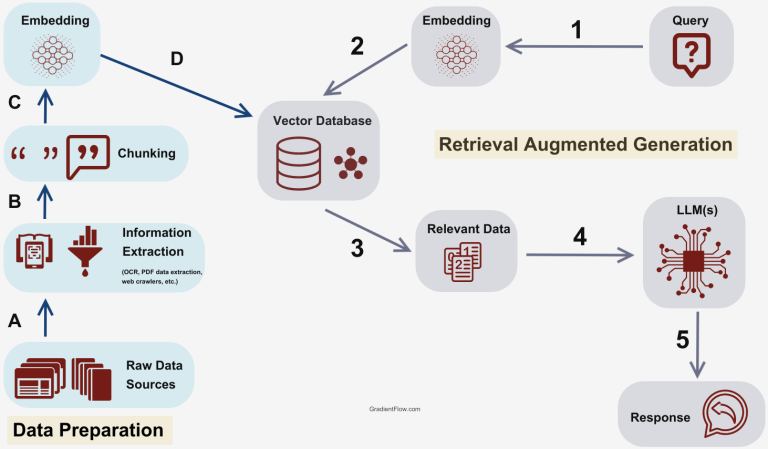

In [16]:

from IPython.display import display, HTML, Image
display(HTML("<style>.container { width:100% !important; }</style>"))
Image(filename='./images/rag-flow.png')


## Vector Databases

In order to search against our corpus/context, we need to store the embeddings somewhere. This is where vector databases come in.

# What is a Vector Database?

Vector databases are a type of database designed to efficiently store, search, and manage vector embeddings. Vector embeddings are high-dimensional vectors that represent complex data in a form that computers can understand and process, such as images, text, or audio. These embeddings are usually generated by ML models to capture the semantic meaning of the data.

## Key Features of Vector Databases

1. **Efficient Similarity Search**: Vector databases are optimized for similarity search, also known as nearest neighbor search. This allows for finding the most similar vectors to a given query vector quickly, even in a large dataset.

2. **High-Dimensional Data Handling**: They are built to handle high-dimensional data efficiently, which is a common characteristic of vector embeddings.

3. **Scalability**: Many vector databases are designed to scale horizontally, allowing them to handle very large datasets by distributing data across multiple nodes.

4. **Integration with Machine Learning Pipelines**: They often provide easy integration with machine learning models and pipelines, facilitating tasks like feature extraction, indexing, and similarity search.

## Use Cases

- **Recommendation Systems**: Vector databases can power recommendation systems by finding items similar to a user's interests. KNN search is often used for this.
- **Image and Video Retrieval**: They can be used to search for images or videos similar to a given input, useful in various applications like stock photo libraries or surveillance.
- **Natural Language Processing (NLP)**: In NLP, vector databases help in semantic search, question answering, and document retrieval by understanding the meaning behind text queries.
- **Fraud Detection**: By analyzing behavioral patterns represented as vectors, vector databases can help identify fraudulent activities.

##  Vector Database Examples

Azure AI Search (formerly Azure Cognitive Search), Qdrant


# Interactive Exploration of Vector Databases

basics of vector databases and how they can be used for similarity search with different techniques



In [5]:
from sentence_transformers import SentenceTransformer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Initialize the SentenceTransformer model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Updated list of sentences with diverse topics
sentences = [
    "How to make an omelette",
    "Ingredients for a cheese omelette",
    "Exploring the surface of Mars",
    "The life cycle of a butterfly",
    "Tips for beginner yoga practitioners",
    "How to change a car tire",
    "Deep sea exploration and its challenges",
    "The history of the Roman Empire",
    "Making the perfect coffee",
    "breaking fast and going slow",
    "Advancements in renewable energy sources"
]

# Generate embeddings (vectors) for each sentence
database_vectors = model.encode(sentences)

# Define a query sentence that is closely related to one of the topics
query_sentence = "how can I make a good breakfast?"

# Encode the query sentence to get its vector representation
query_vector = model.encode([query_sentence])[0]

# Function to find the most similar vectors in the database
def find_similar_vectors(query_vector, database_vectors, top_k=3):
    # Calculate the Euclidean distance from the query vector to each database vector
    distances = np.linalg.norm(database_vectors - query_vector, axis=1)
    # Sort the distances and return the indices of the top_k nearest vectors
    nearest_indices = np.argsort(distances)[:top_k]
    return nearest_indices, distances[nearest_indices]

# Find the nearest vectors to the query
nearest_indices, distances = find_similar_vectors(query_vector, database_vectors)

# Print the indices of the nearest vectors and their distances
print("Indices of nearest vectors:", nearest_indices)
print("Distances of nearest vectors:", distances)

# Optionally, print the most similar sentences
for index in nearest_indices:

    print(sentences[index])


Indices of nearest vectors: [0 8 1]
Distances of nearest vectors: [1.1104498 1.1153839 1.1896421]
How to make an omelette
Making the perfect coffee
Ingredients for a cheese omelette


## Visualizing Semantic Similarity

After finding the nearest vectors to a given query vector, it's insightful to visualize these vectors to understand their semantic similarity. A simple way to do this is by reducing the dimensionality of the vectors to 2D or 3D and plotting them. Here, we'll use PCA (Principal Component Analysis) for dimensionality reduction and matplotlib for plotting.


# Dimensionality Reduction with PCA
First, we'll reduce the dimensions of our vectors to 2D to make them easy to plot.


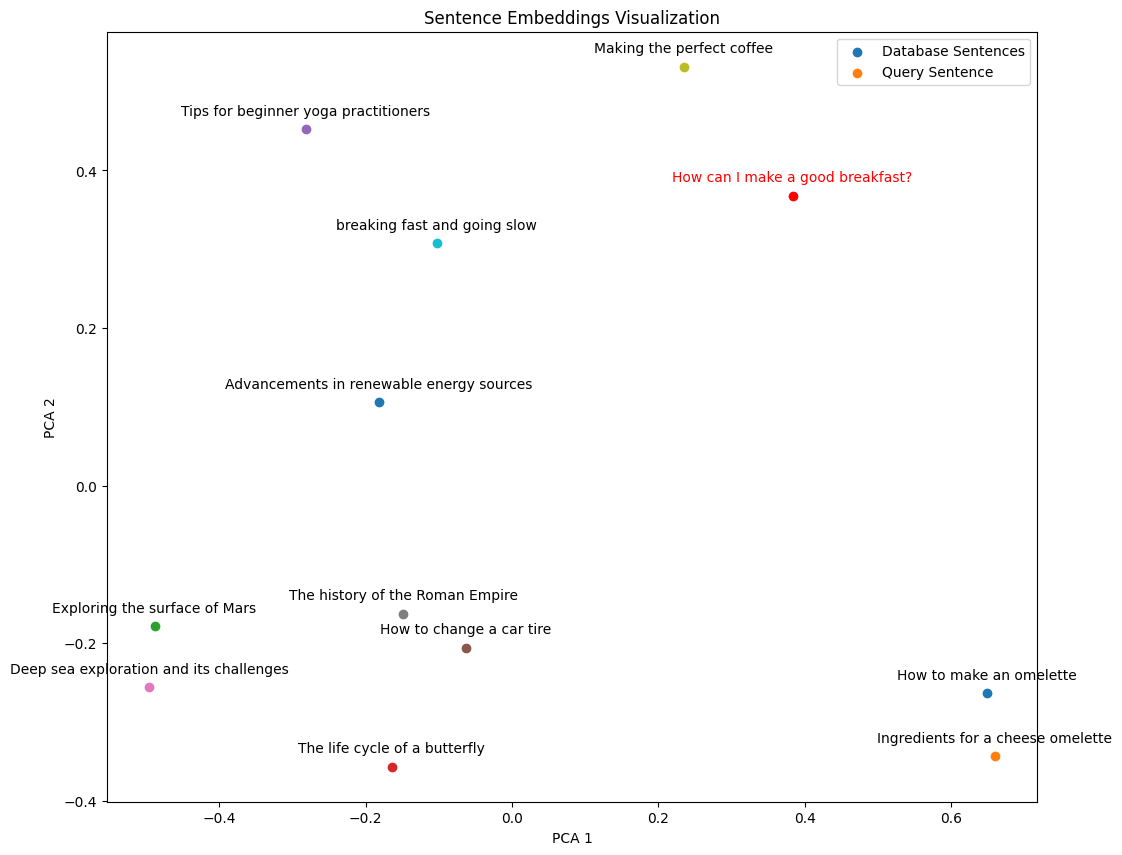

In [9]:
# Generate embeddings
database_vectors = model.encode(sentences)
query_vector = model.encode([query_sentence])[0]

# Combine all vectors for PCA
all_vectors = np.vstack([database_vectors, query_vector])

# Perform PCA to reduce dimensions to 2D for visualization
# The PCA algorithm will identify the two orthogonal directions (principal components) that capture the most variance in the data and project the original data onto these two dimensions. This is often used for data visualization, noise reduction, or to simplify the data for further analysis.
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(all_vectors)

plt.figure(figsize=(12, 10))
# Plot database sentences
for i, vector in enumerate(reduced_vectors[:-1]):
    plt.scatter(vector[0], vector[1])
    plt.annotate(sentences[i], (vector[0], vector[1]), textcoords="offset points", xytext=(0,10), ha='center')
# Plot query sentence
plt.scatter(reduced_vectors[-1, 0], reduced_vectors[-1, 1], color='red')
plt.annotate(query_sentence, (reduced_vectors[-1, 0], reduced_vectors[-1, 1]), textcoords="offset points", xytext=(0,10), ha='center', color='red')

plt.title('Sentence Embeddings Visualization')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(['Database Sentences', 'Query Sentence'], loc='best')
plt.show()

#  visualizing similarity in 3D: Simple Ranking with cosine similarity

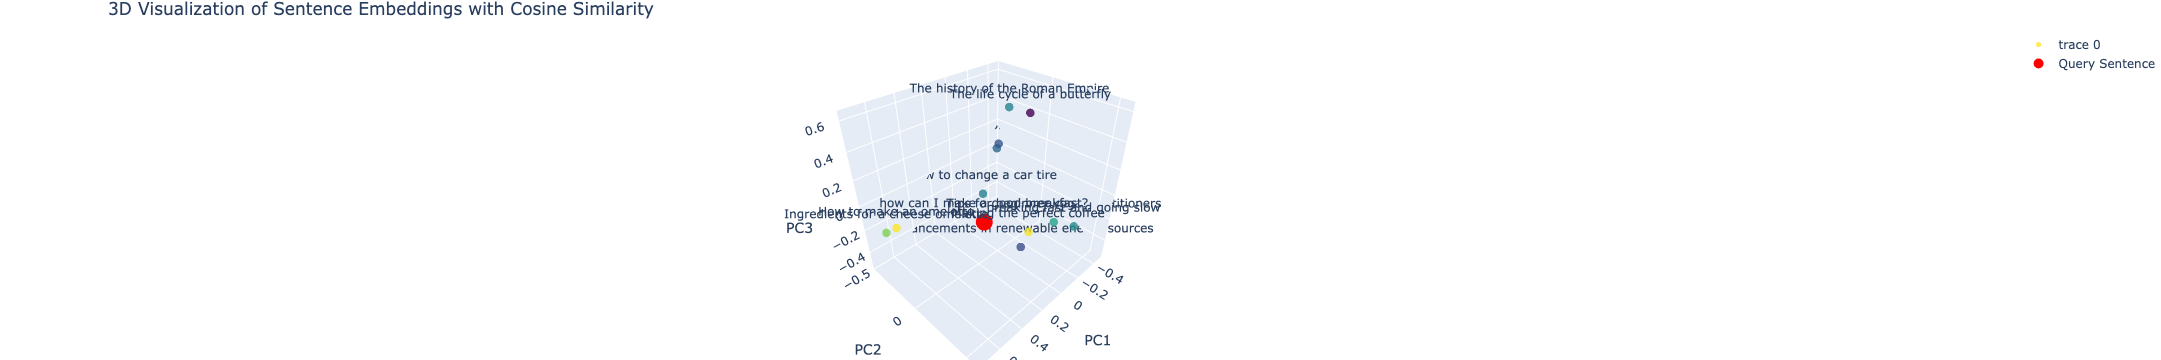

In [7]:
from sentence_transformers import SentenceTransformer
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

# Initialize the SentenceTransformer model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# List of sentences
sentences = [
    "How to make an omelette",
    "Ingredients for a cheese omelette",
    "Exploring the surface of Mars",
    "The life cycle of a butterfly",
    "Tips for beginner yoga practitioners",
    "How to change a car tire",
    "Deep sea exploration and its challenges",
    "The history of the Roman Empire",
    "Making the perfect coffee",
    "breaking fast and going slow",
    "Advancements in renewable energy sources"
]

# Generate embeddings for each sentence
database_vectors = model.encode(sentences)

# Reduce the dimensionality of the vectors to 3D for visualization
pca = PCA(n_components=3)
database_vectors_3d = pca.fit_transform(database_vectors)

# Define and encode the query sentence
query_sentence = "how can I make a good breakfast?"
query_vector = model.encode([query_sentence])[0]
query_vector_3d = pca.transform([query_vector])[0]

# Calculate cosine similarity
#Cosine similarity measures the cosine of the angle between two non-zero vectors in a multi-dimensional space. It is widely used in text processing to assess how similar two documents (or sentences) are in terms of their content. The cosine similarity is particularly useful in high-dimensional spaces, like those used in text analysis and natural language processing, because it is less affected by the size of the document.
query_vector_reshaped = query_vector.reshape(1, -1)
cos_similarities = cosine_similarity(database_vectors, query_vector_reshaped).flatten()

# Normalize cosine similarities for color scale
cos_similarities_normalized = (cos_similarities - cos_similarities.min()) / (cos_similarities.max() - cos_similarities.min())

# Create a 3D scatter plot
fig = go.Figure()

# Plot all database vectors with text and similarity-based color
fig.add_trace(go.Scatter3d(
    x=database_vectors_3d[:, 0],
    y=database_vectors_3d[:, 1],
    z=database_vectors_3d[:, 2],
    mode='markers+text',
    text=sentences,
    marker=dict(size=5, color=cos_similarities_normalized, colorscale='Viridis', opacity=0.8),
    hoverinfo='text',
    hovertext=[f'{sentence} (Similarity: {sim:.2f})' for sentence, sim in zip(sentences, cos_similarities)]
))

# Plot the query vector
fig.add_trace(go.Scatter3d(
    x=[query_vector_3d[0]],
    y=[query_vector_3d[1]],
    z=[query_vector_3d[2]],
    mode='markers+text',
    name='Query Sentence',
    text=[query_sentence],
    marker=dict(size=10, color='red'),
    hoverinfo='text'
))

# Set plot layout
fig.update_layout(
    title='3D Visualization of Sentence Embeddings with Cosine Similarity',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    margin=dict(l=0, r=0, b=0, t=30)
)

# Show plot
fig.show()

## Similarity without reduction

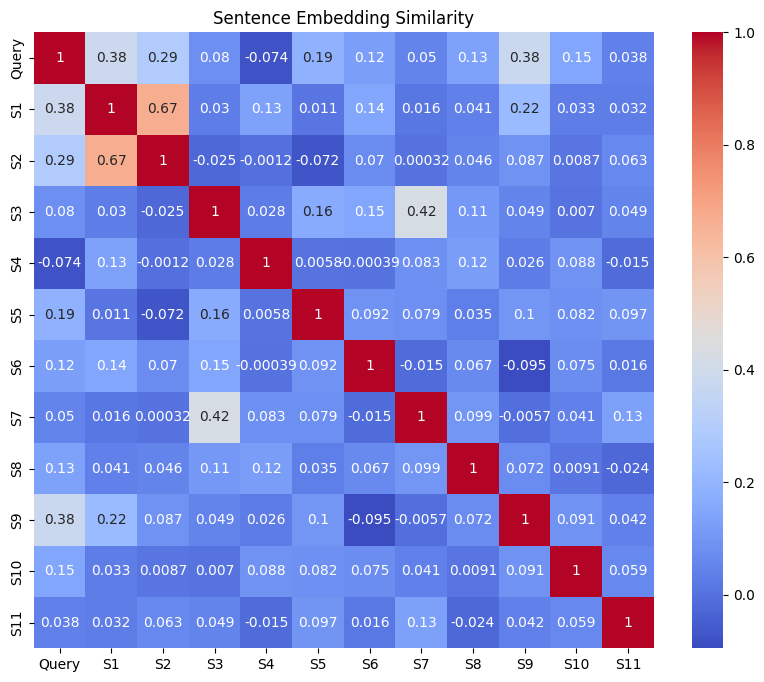

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Initialize the SentenceTransformer model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# List of sentences
sentences = [
    "How to make an omelette",
    "Ingredients for a cheese omelette",
    "Exploring the surface of Mars",
    "The life cycle of a butterfly",
    "Tips for beginner yoga practitioners",
    "How to change a car tire",
    "Deep sea exploration and its challenges",
    "The history of the Roman Empire",
    "Making the perfect coffee",
    "breaking fast and going slow",
    "Advancements in renewable energy sources"
]

# Generate embeddings for each sentence
database_vectors = model.encode(sentences)

# Define and encode the query sentence
query_sentence = "How can I make a good breakfast?"
query_vector = model.encode([query_sentence])

# Combine the query vector with the database vectors for similarity calculation
all_vectors = np.vstack([query_vector, database_vectors])

# Calculate the cosine similarity matrix
similarity_matrix = cosine_similarity(all_vectors)

# Plot the similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm',
            xticklabels=['Query'] + ['S' + str(i) for i in range(1, len(sentences) + 1)],
            yticklabels=['Query'] + ['S' + str(i) for i in range(1, len(sentences) + 1)])
plt.title('Sentence Embedding Similarity')
plt.show()

## Hybrid Search and Reranking: Enhancing Search Accuracy

# Hybrid Search: Making Information Retrieval Better and Faster

Hybrid search is a leading method in finding information quickly and accurately from huge amounts of data. It uses different ways to search, going beyond the usual methods to get the right answers fast.

## Starting Point: Quick and Wide Search

The first step in hybrid search is to find a lot of potentially useful information fast. It does this using simple methods like Euclidean distance and cosine similarity. Euclidean distance looks at the straight line between two points, while cosine similarity checks how similar the directions of two vectors are. This helps in finding a wide range of items quickly.

### Simple Example: Finding Related Documents

Imagine looking for documents that match a specific topic in a big collection. Using Euclidean distance, the system finds documents close to your topic. With cosine similarity, it also looks at how similar the direction of your search is to the documents, picking the ones that match best. This way, you get a broad selection quickly.

## Refining the Search: Making Results More Relevant

After the initial search, the next step is to make these results more relevant. This is done by looking more closely at the information and using advanced methods, like machine learning, to sort through the initial choices and find the best matches.

### Example: Getting More Accurate Results

Let's say the first search results bring up various documents about climate change. To make these results more relevant, the system might use advanced analysis to focus on documents that talk about "marine biodiversity," making sure the results match what you're looking for more closely.

## Benefits: Accurate and Flexible Results

Hybrid search is great because it not only makes search results more accurate by using different methods but also allows for flexibility. This means the results can be adjusted to meet specific needs or interests, making sure the final information is exactly what is needed.

In short, hybrid search combines quick, broad search methods with detailed analysis to make sure users can find the most relevant information for their needs easily.

## Simple hybrid search example
the below code it combines two different methods to improve search relevance and accuracy

1. **Metadata Filtering**: This step quickly narrows down the search scope by filtering documents that only match certain metadata criteria, such as category or tags. It's efficient but might not capture the depth of the content.


We use this to enable multitenancy, by setting up metadata for every customer and making sure the search being applied is relevant to their metadata


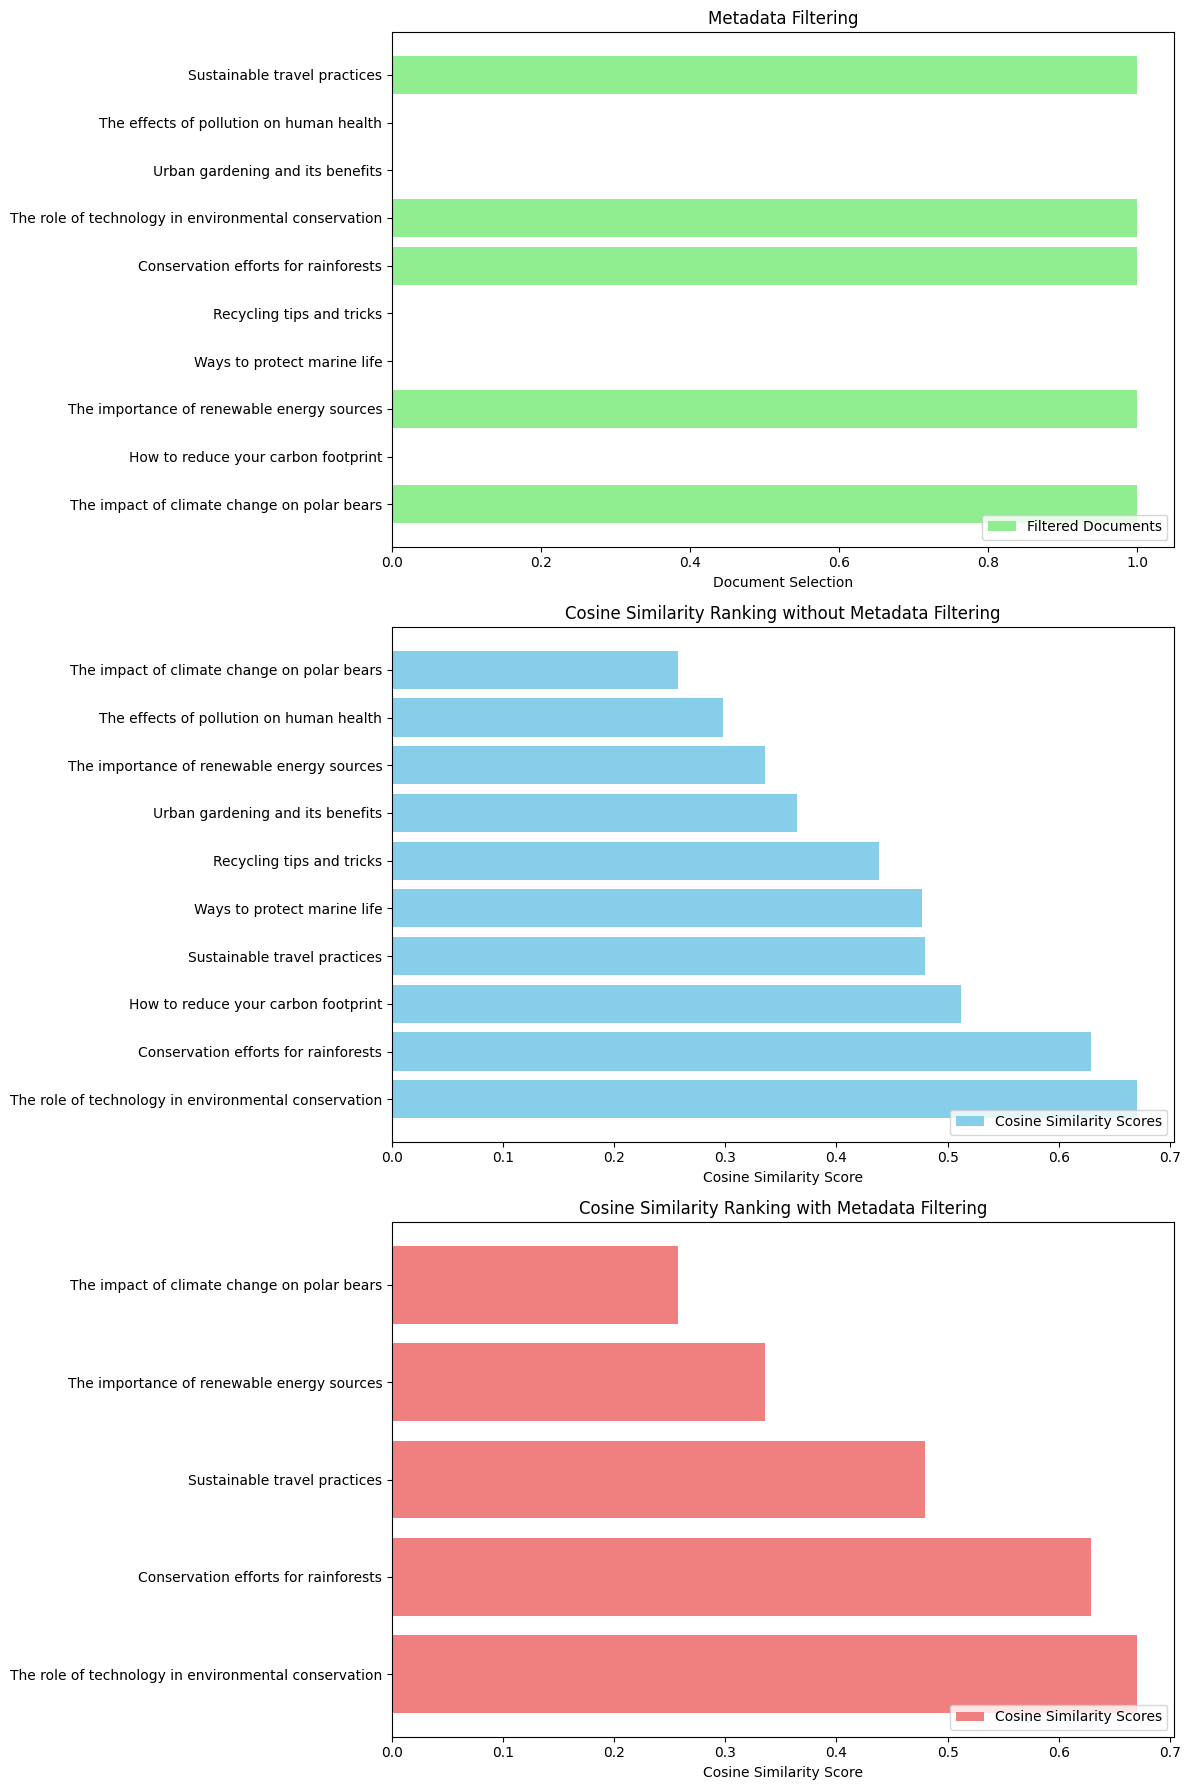

In [21]:
from sentence_transformers import SentenceTransformer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Initialize the model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Document and query sentences
documents = [
    "The impact of climate change on polar bears",
    "How to reduce your carbon footprint",
    "The importance of renewable energy sources",
    "Ways to protect marine life",
    "Recycling tips and tricks",
    "Conservation efforts for rainforests",
    "The role of technology in environmental conservation",
    "Urban gardening and its benefits",
    "The effects of pollution on human health",
    "Sustainable travel practices"
]
query = ["What are effective methods for environmental conservation?"]

# Keywords for metadata search
keywords = ["conservation", "sustainable", "climate", "renewable"]

# Metadata search: Filter documents based on keyword presence
filtered_documents = [doc for doc in documents if any(keyword in doc.lower() for keyword in keywords)]

# Generate embeddings for all documents and the query
all_doc_embeddings = model.encode(documents)
filtered_doc_embeddings = model.encode(filtered_documents)
query_embedding = model.encode(query)

# Compute cosine similarity for ranking without metadata filtering
cos_sim_all = cosine_similarity(all_doc_embeddings, query_embedding).flatten()
ranking_indices_all = np.argsort(-cos_sim_all)

# Compute cosine similarity for ranking with metadata filtering
cos_sim_filtered = cosine_similarity(filtered_doc_embeddings, query_embedding).flatten()
ranking_indices_filtered = np.argsort(-cos_sim_filtered)

# Visualization
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# Visualization 1: Metadata Filtering
axs[0].barh(range(len(documents)), [1 if doc in filtered_documents else 0 for doc in documents], color=['lightgreen' if doc in filtered_documents else 'lightgrey' for doc in documents])
axs[0].set_yticks(range(len(documents)))
axs[0].set_yticklabels(documents)
axs[0].set_title('Metadata Filtering')
axs[0].set_xlabel('Document Selection')
axs[0].legend(['Filtered Documents'], loc='lower right')

# Visualization 2: Cosine Similarity Ranking without Metadata Filtering
axs[1].barh(range(len(documents)), cos_sim_all[ranking_indices_all], color='skyblue')
axs[1].set_yticks(range(len(documents)))
axs[1].set_yticklabels(np.array(documents)[ranking_indices_all])
axs[1].set_title('Cosine Similarity Ranking without Metadata Filtering')
axs[1].set_xlabel('Cosine Similarity Score')
axs[1].legend(['Cosine Similarity Scores'], loc='lower right')

# Visualization 3: Cosine Similarity Ranking with Metadata Filtering
axs[2].barh(range(len(filtered_documents)), cos_sim_filtered[ranking_indices_filtered], color='lightcoral')
axs[2].set_yticks(range(len(filtered_documents)))
axs[2].set_yticklabels(np.array(filtered_documents)[ranking_indices_filtered])
axs[2].set_title('Cosine Similarity Ranking with Metadata Filtering')
axs[2].set_xlabel('Cosine Similarity Score')
axs[2].legend(['Cosine Similarity Scores'], loc='lower right')

plt.tight_layout()
plt.show()

# Next addition we want to make: full text search

Full-text search is a technique used to search a text database. Unlike searching through metadata (like titles or tags), full-text search examines all the words in every stored document. This approach is more comprehensive and can find matches even in the body of texts. It's particularly useful for large databases where information retrieval based on content is required.

### Trigram Index
A trigram index breaks text down into three-character chunks. For example, the word "search" would be broken down into "sea", "ear", "arc", "rch". This allows for efficient searching of partial words, which is useful for typo tolerance and fuzzy matching. It's a specific technique used in full-text search to enhance search capabilities, especially in languages where word boundaries are not clear or in datasets with frequent spelling errors.

#### After reranking : Full-Text Search with Trigram Index

 **Full-Text Search with Trigram Index**: Within the filtered subset (the slide above), a more detailed search is performed on the content of the documents. The trigram index allows for flexible matching, catching variations and partial matches that a straightforward text comparison might miss.

This hybrid approach leverages the efficiency of metadata filtering to narrow down the search space and the comprehensiveness of full-text search to ensure the relevance and accuracy of the results. It's particularly useful in scenarios where both broad categorization and deep content analysis are necessary to satisfy search queries.

 A trigram is a set of three consecutive characters taken from a given text. For example, the word "Hello" would produce the trigrams: "Hel", "ell", "llo".
Use in Search: Trigrams can be used to perform fuzzy searches, allowing for typo tolerance and partial matches.


Our usecase: if a customer refers to Account (4000) (with an alias) as just a substring eg (4000) , we want to be able to match the relevant data



In [22]:
# Step 1: Generate Trigrams from Text
def generate_trigrams(text):
    return set(text[i:i+3] for i in range(len(text)-2))
documents = [
    "The impact of climate change on polar bears",
    "How to reduce your carbon footprint",
    "The importance of renewable energy sources",
    "Ways to protect marine life",
    "Recycling tips and tricks",
    "Conservation efforts for rainforests",
    "The role of technology in environmental conservation",
    "Urban gardening and its benefits",
    "The effects of pollution on human health",
    "Sustainable travel practices"
]

# Step 2: Indexing Documents
# Creates a trigram index from the documents
trigram_index = {}  # Initialize the trigram index
for doc_id, doc in enumerate(documents):
    for trigram in generate_trigrams(doc.lower()):
        if trigram in trigram_index:
            trigram_index[trigram].add(doc_id)
        else:
            trigram_index[trigram] = {doc_id}


# Step 3: Implementing Search
def search(query):
    query_trigrams = generate_trigrams(query.lower())
    matched_docs = set()
    for trigram in query_trigrams:
        if trigram in trigram_index:
            matched_docs.update(trigram_index[trigram])
    return [documents[doc_id] for doc_id in matched_docs]

# Step 4: Demonstrating Robustness to Misspellings and Substrings
queries = [
    "omentenviral conservashun",  # Misspelled
    "renewable energy",           # Substring
    "polr bears",                 # Misspelled
    "carbon foot",                # Substring
]

for query in queries:
    print(f"Search Results for: '{query}'")
    print(search(query))
    print()

Search Results for: 'omentenviral conservashun'
['Conservation efforts for rainforests', 'The role of technology in environmental conservation']

Search Results for: 'renewable energy'
['The importance of renewable energy sources', 'The role of technology in environmental conservation', 'Urban gardening and its benefits', 'The effects of pollution on human health', 'Sustainable travel practices']

Search Results for: 'polr bears'
['The impact of climate change on polar bears', 'The effects of pollution on human health', 'Urban gardening and its benefits']

Search Results for: 'carbon foot'
['The impact of climate change on polar bears', 'How to reduce your carbon footprint', 'Conservation efforts for rainforests', 'The effects of pollution on human health']



## Up Next: Evaluation Methods with Promptflow

# Evaluation Methods with Promptflow

Prompt flow is an [open source suite of development tools from MSFT](https://microsoft.github.io/promptflow/) designed to streamline the end-to-end development cycle of LLM-based AI applications.

* Allows developers to create DAG based workflows with LLMs, prompts, and code
* Baked in development tools for experimentation and observability
* First class benchmarking/evaluation support


## Anatomy of a flow

* Flows are essentially functions with expected inputs/outputs
* Each `node` in a `flow` represents some intermediary step in a `flow` and can be run in parallel
* An invocation of a `flow` is called a `run` and PF automatically captures metadata about aspects of that `run`

![image](images/pf-dag-screenshot.png)

## Example Flow Overview

RAG-based flow that looks up documentation and uses that info to write a tweet about a given topic with references.

* Built in UIs greatly help with inspecting each phase of a test
* Tracking token usage
* Batch runs for testing a flow against a dataset

Testing a flow with single input:
```
pf flow test --flow promptflow/qdrant_tweet_flow --inputs topic=Microsoft
```

Batch running flow against a dataset:
```
pf run create --flow promptflow/qdrant_tweet_flow \
--data promptflow/evaluation_flow/data.jsonl \
--column-mapping topic='${data.topic}'
```

## Evaluations + Benchmarking

* Evaluations are also flows and can run against output of previous runs
* With a combination of validation datasets and run outputs, we can set thresholds for success

Batch running evaluation flow against existing run:
```
pf run create --flow promptflow/evaluation_flow \
--data promptflow/evaluation_flow/data.jsonl \
--column-mapping relevance_threshold='${data.relevance_threshold}' tweet='${run.outputs.tweet}' references='${run.outputs.references}' \
--run qdrant_tweet_flow_variant_0_20240724_190216_041293
```

# Summary

![image](images/summary.png)

# Thank You!

Code + Slides can be found here: https://github.com/khchan/building-blocks-ai